In [415]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, fbeta_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer # Handle NaNs
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [407]:
# XGBoost boosting ensemble classifier
# Refs:
# https://xgboost.readthedocs.io/en/stable/python/python_intro.html

# Path to feature CSVs
features_dir = os.path.join("..", "data", "calculated_features", "N500_all_features")
databases = ['BIDMC-CHF', 'CHF-RR', 'NSR', 'NSR-RR', 'FD']

# Train/val/test sets subjects, overview
data_dir = os.path.join("..", "data", "dataset_splits")
# Select which data splits to use
splits_folder = "generated_splits_2"
splits_path = os.path.join(data_dir, splits_folder)

# Select which subset of the data to consider
subset = "all_dbs"
#subset = "db1"
#subset = "db2"

if subset == "db1":
    filename_train = "db1_training_set.csv"
    filename_val = "db1_validation_set.csv"
    filename_test = "db1_test_set.csv"
elif subset == "db2":
    filename_train = "db2_training_set.csv"
    filename_val = "db2_validation_set.csv"
    filename_test = "db2_test_set.csv"
elif subset == "all_dbs":
    filename_train = "all_dbs_training_set.csv"
    filename_val = "all_dbs_validation_set.csv"
    filename_test = "all_dbs_test_set.csv"
else:
    print("Error: The 'subset' variable must be set to \"db_1\", \"db_2\" or \"all_dbs\".")

path_train = os.path.join(splits_path, filename_train)
path_val = os.path.join(splits_path, filename_val)
path_test = os.path.join(splits_path, filename_test)

df_train_subjects = pd.read_csv(path_train)
df_val_subjects = pd.read_csv(path_val)
df_test_subjects = pd.read_csv(path_test)
#Columns: subject_id	database	CHF
#Example values: 16265	NSR	0

# Extract the features of the subjects in the training, validation and test sets

# Data splits info and placeholders for the corresponding DataFrames to contain their features
data_splits = [
    {'subjects_df': df_train_subjects, 'features_df': None},
    {'subjects_df': df_val_subjects, 'features_df': None},
    {'subjects_df': df_test_subjects, 'features_df': None}
]

for data_split in data_splits:
    # Subjects in the current split, as well as the (currently empty) corresponding features dataframe
    subjects_info_df = data_split['subjects_df']

    list_of_feature_dfs = [] # To store temporary feature DataFrames before concatenation

    # Loop through the subjects
    for index, subj_row in subjects_info_df.iterrows():
        db_name = subj_row['database']
        if db_name == 'Fantasia':
            db_name = 'FD'
        subject_id = subj_row['subject_id']
        
        # Retrieve the features of that subject and put it in the relevant Dataframe
        subject_features_file = f'{db_name}_{subject_id}_features.csv'
        path_subject_features = os.path.join(features_dir, db_name, subject_features_file)

        if os.path.exists(path_subject_features):
            try:
                df_subject_features = pd.read_csv(path_subject_features)
                list_of_feature_dfs.append(df_subject_features)
                
            except FileNotFoundError:
                print(f"Error: Feature CSV not found for subject {subject_id} in database {db_name} at path: {path_subject_features}")
            except pd.errors.EmptyDataError:
                print(f"Warning: Feature CSV is empty for subject {subject_id} in database {db_name} at path: {path_subject_features}")
        else:
            print(f"Warning: Feature CSV path does not exist: {path_subject_features}")
    
    # Concatenate all subject feature DataFrames for this split
    if list_of_feature_dfs: # Only concatenate if there are DataFrames in the list
        data_split['features_df'] = pd.concat(list_of_feature_dfs, ignore_index=True) # Update the features_df in split_info

# Put the retrieved features into DataFrames
df_train = data_splits[0]['features_df']
df_val = data_splits[1]['features_df']
df_test = data_splits[2]['features_df']


In [408]:
# Create additional dataframe for test set, if wanting to evaluate a model for a different subset of the data than 
# what it was trained on.
# Run this cell and the cell below to update X_test_eval and y_test_eval.

# Select which subset of the data to consider
#subset_eval = "all_dbs"
subset_eval = "db1"
#subset_eval = "db2"

if subset_eval == "db1":
    filename_test_eval = "db1_test_set.csv"
elif subset_eval == "db2":
    filename_test_eval = "db2_test_set.csv"
elif subset_eval == "all_dbs":
    filename_test_eval = "all_dbs_test_set.csv"
else:
    print("Error: The 'subset' variable must be set to \"db_1\", \"db_2\" or \"all_dbs\".")

path_test_eval = os.path.join(splits_path, filename_test_eval)

# Subjects info
df_test_subjects_eval = pd.read_csv(path_test_eval)
#Columns: subject_id	database	CHF
#Example values: 16265	NSR	0

features_df_eval = None

list_of_feature_dfs_eval = [] # To store temporary feature DataFrames before concatenation

# Loop through the subjects
for index, subj_row in df_test_subjects_eval.iterrows():
    db_name = subj_row['database']
    if db_name == 'Fantasia':
        db_name = 'FD'
    subject_id = subj_row['subject_id']
    
    # Retrieve the features of that subject and put it in the relevant Dataframe
    subject_features_file = f'{db_name}_{subject_id}_features.csv'
    path_subject_features = os.path.join(features_dir, db_name, subject_features_file)

    if os.path.exists(path_subject_features):
        try:
            df_subject_features = pd.read_csv(path_subject_features)
            list_of_feature_dfs_eval.append(df_subject_features)
            
        except FileNotFoundError:
            print(f"Error: Feature CSV not found for subject {subject_id} in database {db_name} at path: {path_subject_features}")
        except pd.errors.EmptyDataError:
            print(f"Warning: Feature CSV is empty for subject {subject_id} in database {db_name} at path: {path_subject_features}")
    else:
        print(f"Warning: Feature CSV path does not exist: {path_subject_features}")

# Concatenate all subject feature DataFrames for this split
if list_of_feature_dfs_eval: # Only concatenate if there are DataFrames in the list
    features_df_eval = pd.concat(list_of_feature_dfs_eval, ignore_index=True) # Update the features_df in split_info

df_test_eval = features_df_eval

print(f"Data subset: {subset_eval}")

Data subset: db1


In [409]:
# XGBoost, with the Scikit-Learn API

# Prepare the data

# Columns of df_train, df_val and df_test:
# ['subject_id', 'database', 'label', 'segment_id', 'feature1', ... , 'featureN'].

# Identify the columns to use as features:
excluded_columns = ['subject_id', 'database', 'segment_id', 'label']
feature_cols = [col for col in df_train.columns if col not in excluded_columns]

# Identify non-zero columns in the training set
non_zero_feature_cols = [col for col in feature_cols if df_train[col].nunique() > 1]

# X and y for training
X_train = df_train[non_zero_feature_cols]

y_train = df_train['label']  # or 'CHF', whichever your column is called

# X and y for validation
X_val = df_val[non_zero_feature_cols]
y_val = df_val['label']

# X and y for test
X_test = df_test[non_zero_feature_cols]
y_test = df_test['label']

X_test_eval = df_test_eval[non_zero_feature_cols]
y_test_eval = df_test_eval['label']


In [410]:
# Train with standard hyperparameter values first. (Compare performance with using hyperparameter tuning later.)

# XGBoost classifier with default settings
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='error', early_stopping_rounds=10)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Save the model
xgb_clf.save_model(os.path.join("..", "models", "xgboost", "xgb_model_default.json"))

# Evaluate on the test set
y_test_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print("\nModel accuracy (test set) (default hyperparameters):", accuracy)

# Calculate sensitivity and specificity from the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("Model sensitivity (test set) (default hyperparameters):", sensitivity)
print("Model specificity (test set) (default hyperparameters):", specificity)


[0]	validation_0-error:0.20005
[1]	validation_0-error:0.18596
[2]	validation_0-error:0.18388
[3]	validation_0-error:0.18434
[4]	validation_0-error:0.18249
[5]	validation_0-error:0.18064
[6]	validation_0-error:0.18341
[7]	validation_0-error:0.18341
[8]	validation_0-error:0.18203
[9]	validation_0-error:0.18087
[10]	validation_0-error:0.18203
[11]	validation_0-error:0.18249
[12]	validation_0-error:0.18249
[13]	validation_0-error:0.18249
[14]	validation_0-error:0.18295
[15]	validation_0-error:0.18295

 0.7399279397314117t set) (default hyperparameters):
Model sensitivity (test set) (default hyperparameters): 0.5789192081326913
Model specificity (test set) (default hyperparameters): 0.9940878378378378


In [411]:
# Create helper function for printing performance
def evaluate_performance(X, y, model):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Model accuracy:", accuracy)
    
    # Calculate sensitivity and specificity from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print("Model sensitivity:", sensitivity)
    print(f"Model specificity: {specificity}\n")

print("Training set:")
evaluate_performance(X_train, y_train, xgb_clf)
print("Validation set:")
evaluate_performance(X_val, y_val, xgb_clf)
print("Test set:")
evaluate_performance(X_test, y_test, xgb_clf)

Training set:
Model accuracy: 0.9271395309216878
Model sensitivity: 0.8415841584158416
Model specificity: 0.9731830887491265

Validation set:
Model accuracy: 0.8193578193578194
Model sensitivity: 0.588671611598112
Model specificity: 0.9395643007730148

Test set:
Model accuracy: 0.7399279397314117
Model sensitivity: 0.5789192081326913
Model specificity: 0.9940878378378378



In [412]:
# Train with hyperparameter tuning. Optuna.

# Define an objective function for Optuna to minimize (or maximize).
# Here we use negative cross-validated accuracy (so that maximizing accuracy becomes a minimization task)
def objective(trial):
    # Suggest values for hyperparameters.
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
    }
    
    # Create the model with these hyperparameters
    model = xgb.XGBClassifier(**param)
    
    # Use cross-validation (e.g., 3-fold) on the training set.
    # Here we use accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    
    # Since we want to maximize accuracy, we can return the negative mean accuracy (so Optuna minimizes this)
    return -np.mean(cv_scores)

# Create an Optuna study. Setting direction to 'minimize' since our objective returns negative accuracy.
study = optuna.create_study(direction='minimize')

# Run the optimization for a given number of trials.
study.optimize(objective, n_trials=15)

# Output the best hyperparameters and corresponding score.
print("Best hyperparameters:", study.best_params)
print("Best cross-validated score (negative accuracy):", study.best_value)

[I 2025-03-20 16:35:13,778] A new study created in memory with name: no-name-6f104aab-8dec-49ed-b843-9423e6e38ecb
[I 2025-03-20 16:35:29,138] Trial 0 finished with value: -0.8741519968101583 and parameters: {'max_depth': 3, 'learning_rate': 0.0184737828058725, 'n_estimators': 172, 'subsample': 0.8918370608373873, 'colsample_bytree': 0.6864640857936462, 'gamma': 1.5106764467107736, 'reg_alpha': 0.37939407715666984, 'reg_lambda': 0.7871682198973016}. Best is trial 0 with value: -0.8741519968101583.
[I 2025-03-20 16:35:35,948] Trial 1 finished with value: -0.8664855400065928 and parameters: {'max_depth': 8, 'learning_rate': 0.07118270503771208, 'n_estimators': 340, 'subsample': 0.510859325129676, 'colsample_bytree': 0.5494487096381192, 'gamma': 1.9018928780550044, 'reg_alpha': 0.46576906754424297, 'reg_lambda': 0.3481886191987984}. Best is trial 0 with value: -0.8741519968101583.
[I 2025-03-20 16:35:39,895] Trial 2 finished with value: -0.8680190403596061 and parameters: {'max_depth': 6, 

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.012313578904846198, 'n_estimators': 153, 'subsample': 0.8142758535759824, 'colsample_bytree': 0.6132357799663961, 'gamma': 3.1592165850496396, 'reg_alpha': 0.7012203437097952, 'reg_lambda': 0.8068847275407255}
Best cross-validated score (negative accuracy): -0.8745493917985422


In [416]:
# Train the model with the tuned hyperparameters

best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_params['random_state'] = 42

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

print("Training set:")
evaluate_performance(X_train, y_train, best_model)
print("Validation set:")
evaluate_performance(X_val, y_val, best_model)
print("Test set:")
evaluate_performance(X_test, y_test, best_model)

Training set:
Model accuracy: 0.9087398489408826
Model sensitivity: 0.8135043012497971
Model specificity: 0.9599930118798043

Validation set:
Model accuracy: 0.8316008316008316
Model sensitivity: 0.6250842886041807
Model specificity: 0.9392129304286718

Test set:
Model accuracy: 0.7543399934490664
Model sensitivity: 0.6008560727661851
Model specificity: 0.9966216216216216



In [414]:
# Scoring metric F-beta
# Hyperparameter tuning, but now with F2 score as scoring metric (rather than 'accuracy')

# Define an F-beta scorer (F-beta with beta > 1 gives more weight to recall (sensitivity))
beta_value = 3
fbeta_scorer = make_scorer(fbeta_score, beta=beta_value)

# Define an objective function for Optuna to minimize (or maximize).
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
    }
    
    # Create the model with these hyperparameters
    model = xgb.XGBClassifier(**param)
    
    # Use cross-validation (e.g., 3-fold) on the training set.
    # F2-measure as scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=fbeta_scorer, n_jobs=-1)
    
    # Since we want to maximize the scoring metric, we can return the negative mean (since Optuna minimizes it)
    return -np.mean(cv_scores)

# Create an Optuna study. Setting direction to 'minimize' since our objective returns negative accuracy.
study_fbeta = optuna.create_study(direction='minimize')

# Run the optimization for a given number of trials.
study_fbeta.optimize(objective, n_trials=20)

# Output the best hyperparameters and corresponding score.
print("Best hyperparameters:", study_fbeta.best_params)
print("Best cross-validated score:", study_fbeta.best_value)

[I 2025-03-20 16:37:44,303] A new study created in memory with name: no-name-c64c3685-6da7-4b8a-a600-342f19ee6e93
[I 2025-03-20 16:37:53,550] Trial 0 finished with value: -0.7608159593388478 and parameters: {'max_depth': 10, 'learning_rate': 0.021514163493297628, 'n_estimators': 193, 'subsample': 0.630048932960007, 'colsample_bytree': 0.5843978518358799, 'gamma': 0.6442535832904212, 'reg_alpha': 0.6125175920089398, 'reg_lambda': 0.8437519346457196}. Best is trial 0 with value: -0.7608159593388478.
[I 2025-03-20 16:37:56,689] Trial 1 finished with value: -0.7542735893977689 and parameters: {'max_depth': 3, 'learning_rate': 0.0932577429625072, 'n_estimators': 452, 'subsample': 0.7456950801389386, 'colsample_bytree': 0.6212689461994941, 'gamma': 2.2750155086932944, 'reg_alpha': 0.229284337405119, 'reg_lambda': 0.9826038700610493}. Best is trial 0 with value: -0.7608159593388478.
[I 2025-03-20 16:37:57,817] Trial 2 finished with value: -0.758877054207128 and parameters: {'max_depth': 4, 'l

Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.018385767707100126, 'n_estimators': 137, 'subsample': 0.9337977229774135, 'colsample_bytree': 0.6644032826013408, 'gamma': 4.980295380424603, 'reg_alpha': 0.8551605779082023, 'reg_lambda': 0.8219201410885808}
Best cross-validated score: -0.7658702867802941


In [417]:
# Train the model with the tuned hyperparameters
best_params_fbeta = study_fbeta.best_params
best_params_fbeta['objective'] = 'binary:logistic'
best_params_fbeta['eval_metric'] = 'logloss'
best_params_fbeta['random_state'] = 42

model_best_params_fbeta = xgb.XGBClassifier(**best_params_fbeta)
model_best_params_fbeta.fit(X_train, y_train)

print(f"Performance using F-beta as scoring metric, beta={beta_value}:")
print("Training set:")
evaluate_performance(X_train, y_train, model_best_params_fbeta)
print("Validation set:")
evaluate_performance(X_val, y_val, model_best_params_fbeta)
print("Test set:")
evaluate_performance(X_test, y_test, model_best_params_fbeta)

Performance using F-beta as scoring metric, beta=3:
Training set:
Model accuracy: 0.9331591799647907
Model sensitivity: 0.855705242655413
Model specificity: 0.9748427672955975

Validation set:
Model accuracy: 0.8251328251328252
Model sensitivity: 0.5987862440997977
Model specificity: 0.9430780042164442

Test set:
Model accuracy: 0.7382902063544055
Model sensitivity: 0.5751738897806313
Model specificity: 0.995777027027027



In [ ]:
# Select model and get estimated probabilities for later calculations/plots

# Select model
#model = xgb_clf # Default parameters
model = best_model # Optuna tuned parameters
#model = model_best_params_f2

# Get estimated probabilities
y_proba = model.predict_proba(X_test)[:, 1]

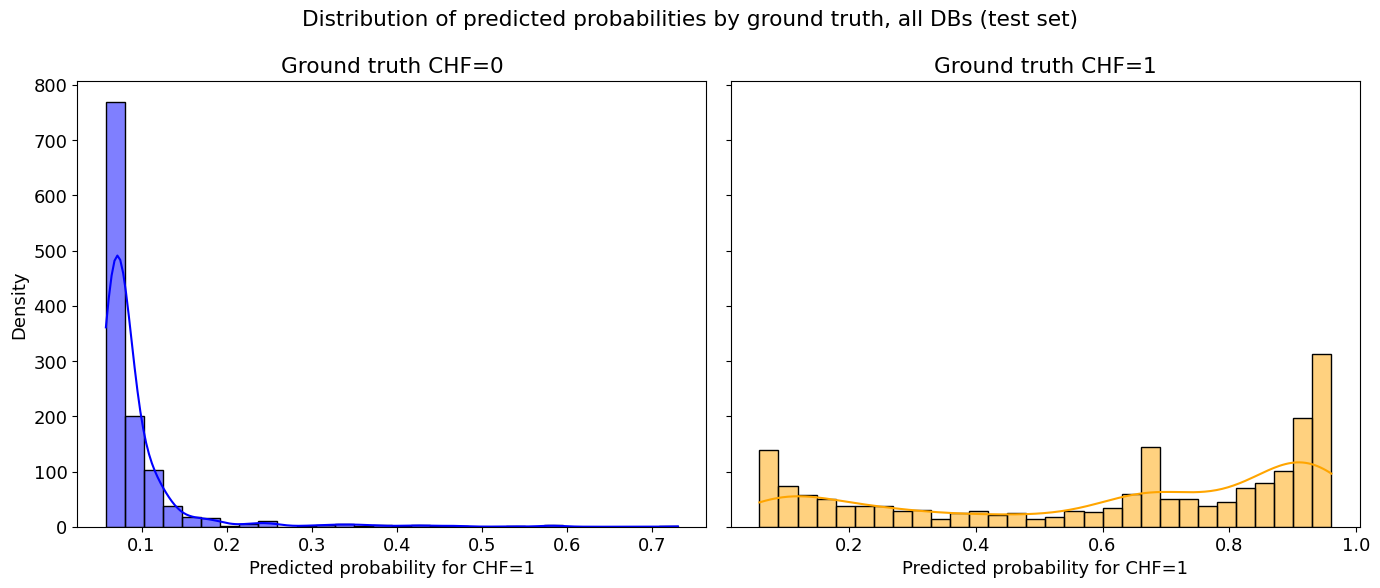

In [81]:
# Plot the distribution of predicted probabilities for ground truth labels y=0 and y=1. 

df = pd.DataFrame({
    'predicted_probability': y_proba,
    'ground_truth': y_test
})

plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for ground truth = 0
sns.histplot(df[df['ground_truth'] == 0]['predicted_probability'], bins=30,
             kde=True, ax=axes[0], color='blue')
axes[0].set_title("Ground truth CHF=0")
axes[0].set_xlabel("Predicted probability for CHF=1")
axes[0].set_ylabel("Density")

# Plot for ground truth = 1
sns.histplot(df[df['ground_truth'] == 1]['predicted_probability'], bins=30,
             kde=True, ax=axes[1], color='orange')
axes[1].set_title("Ground truth CHF=1")
axes[1].set_xlabel("Predicted probability for CHF=1")

if subset == "db1":
    db_print = "DB1"
elif subset == "db2":
    db_print = "DB2"
elif subset == "all_dbs":
    db_print = "all DBs"

plt.suptitle(f"Distribution of predicted probabilities by ground truth, {db_print} (test set)")
plt.tight_layout()
plt.show()

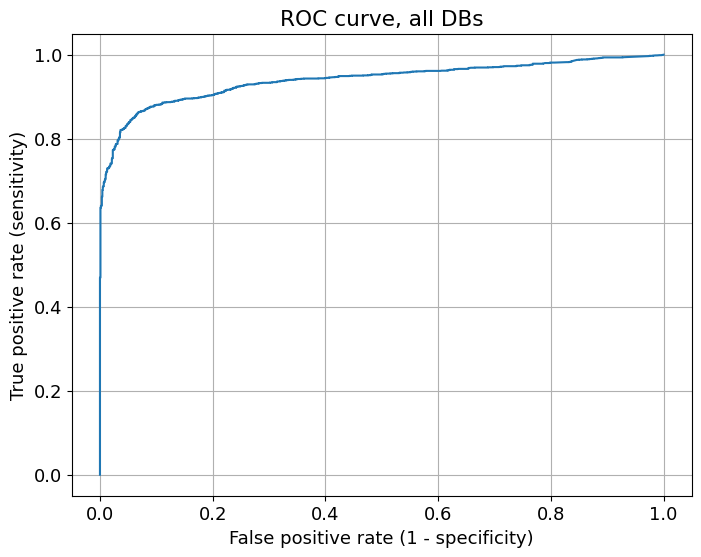


AUC: 0.94




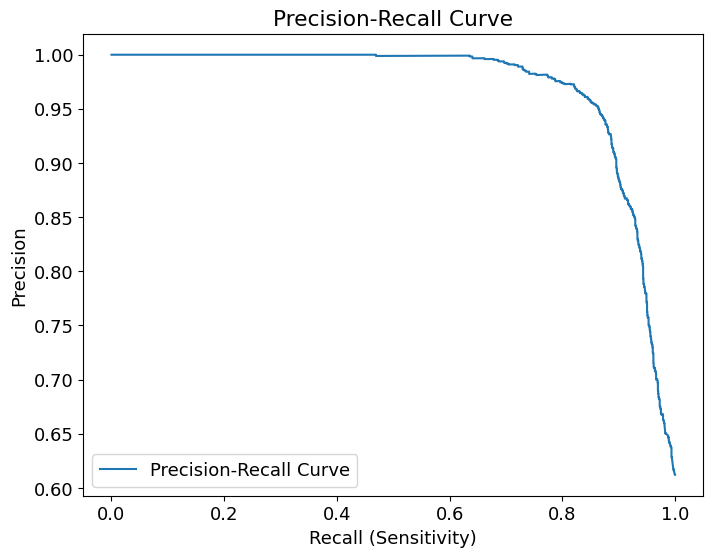

In [82]:
## Plot ROC curve to get an overview over threshold trade-offs

# Assume you have a trained model (e.g., XGBoost) and test data X_test, y_test
y_proba = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel("False positive rate (1 - specificity)")
plt.ylabel("True positive rate (sensitivity)")
plt.title(f"ROC curve, {db_print}")
plt.grid(True)
plt.show()

auc_score = roc_auc_score(y_test, y_proba)
print(f"\nAUC: {auc_score:.2f}\n\n")

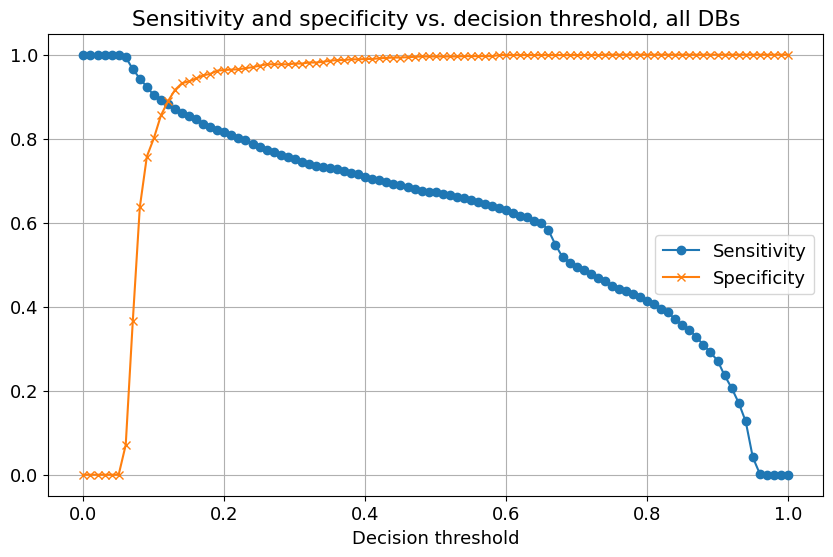

In [83]:
# plot sensitivity and specificity (y axis) vs. decision threshold (between 0 and 1) (x axis) 
# (to get more direct information about what decision threshold to choose)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example: Assume these are your ground truth labels and predicted probabilities for the positive class.
# y_test should be a 1D array-like of true labels (0 or 1).
# y_proba should be a 1D array-like of predicted probabilities for class 1 (CHF positive).
# For example:
# y_test = np.array([...])
# y_proba = model.predict_proba(X_test)[:, 1]

# Create a range of thresholds from 0 to 1
thresholds = np.linspace(0, 1, 101)
sensitivities = []  # True Positive Rate
specificities = []  # True Negative Rate

# Loop over thresholds to compute sensitivity and specificity at each threshold
for thresh in thresholds:
    # Generate binary predictions based on the threshold
    y_pred = (y_proba >= thresh).astype(int)
    
    # Compute the confusion matrix: returns [TN, FP, FN, TP]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate sensitivity (TPR) and specificity (TNR)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sensitivities, label="Sensitivity", marker="o")
plt.plot(thresholds, specificities, label="Specificity", marker="x")
plt.xlabel("Decision threshold")
#plt.ylabel("Metric value")
plt.title(f"Sensitivity and specificity vs. decision threshold, {db_print}")
plt.legend()
plt.grid(True)
plt.show()

In [276]:
## Evaluate performance of the model with different decision thresholds

def evaluate_threshold(y_true, y_proba, threshold):
    """
    Evaluate model performance for a given decision threshold.
    
    Parameters:
    - y_true: Ground truth binary labels (0 or 1).
    - y_proba: Predicted probabilities for the positive class.
    - threshold: Decision threshold for converting probabilities to class predictions.
    
    Returns:
    - accuracy: Overall accuracy.
    - sensitivity: True positive rate (TPR).
    - specificity: True negative rate (TNR).
    """
    # Convert predicted probabilities into binary predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute the confusion matrix: TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return accuracy, sensitivity, specificity
    

def get_performance(y_true, y_proba, thresholds):
    accuracies = []
    sensitivities = []
    specificities = []
    
    for thresh in threshold_values:
        acc, sens, spec = evaluate_threshold(y_true, y_proba, thresh)
        accuracies.append(acc)
        sensitivities.append(sens)
        specificities.append(spec)

    return accuracies, sensitivities, specificities


def plot_performance(y_true, y_proba, thresholds, custom_title=None):
    accuracies, sensitivities, specificities = get_performance(y_true, y_proba, thresholds)
    
    plt.figure(figsize=(10, 6))
    plt.plot(threshold_values, accuracies, label="Accuracy", marker="^", markersize=3)
    plt.plot(threshold_values, sensitivities, label="Sensitivity (TPR)", marker="o", markersize=3)
    plt.plot(threshold_values, specificities, label="Specificity", marker="x", markersize=3)
    plt.xlabel("Decision threshold")
    if custom_title:
        plt.title(custom_title)
    else:
        plt.title(f"Accuracy, sensitivity and specificity vs. decision threshold, {db_print}")
    plt.legend()
    plt.grid(True)
    plt.show()


# Different variant of plotting function, for adding multiple plots to one figure 
def add_plot_to_ax(ax, y_true, y_proba, thresholds, custom_title=None):
    accuracies, sensitivities, specificities = get_performance(y_true, y_proba, thresholds)
    
    ax.plot(thresholds, accuracies, label="Accuracy", marker="^", markersize=3)
    ax.plot(thresholds, sensitivities, label="Sensitivity (TPR)", marker="o", markersize=3)
    ax.plot(thresholds, specificities, label="Specificity", marker="x", markersize=3)
    ax.set_xlabel("Decision threshold")

    if custom_title:
        ax.set_title(custom_title)
    else:
        ax.set_title(f"Accuracy, sensitivity and specificity vs. decision threshold, {db_print}")

    ax.legend()
    ax.grid(True)

1.858139912351891
selected_model: sample_weights


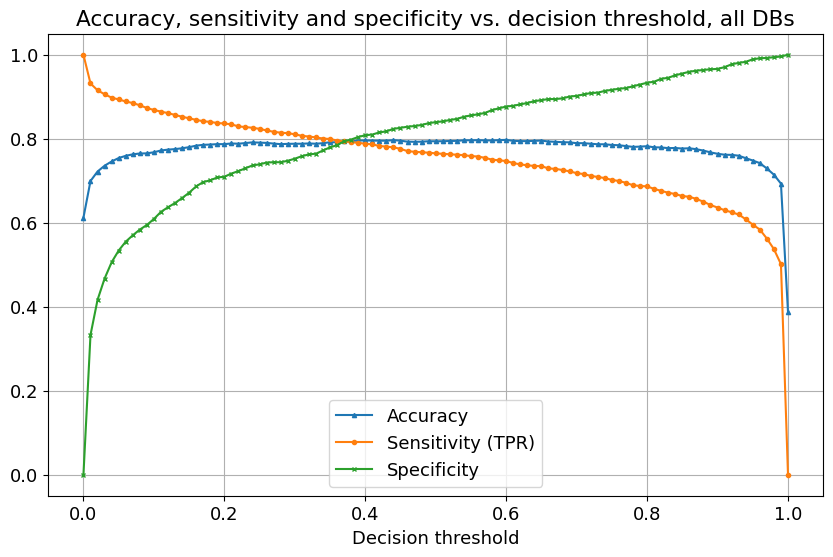

In [89]:
# Another approach: During XGBoost training, prioritize false negatives (actual CHF=1 classified as CHF=0).
# XGBoost parameter: scale_pos_weight

# X_train, y_train: training data.
# Calculate scale_pos_weight:
num_negative = (y_train == 0).sum()
num_positive = (y_train == 1).sum()
scale_pos_weight = num_negative / num_positive
#scale_pos_weight = num_positive / num_negative
#scale_pos_weight = 100

#selected_model == "best_model"
#selected_model = "scale_pos_weight"
selected_model = "sample_weights" 

if selected_model == "best_model": # Fitted parameters. But no further adjustments to prioritize false negatives.
    # Assume you have a trained model (e.g., XGBoost) and test data X_test, y_test
    model = best_model
elif selected_model == "scale_pos_weight":
    # Initialize the classifier with the computed scale_pos_weight
    model_cs = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,   # if using newer XGBoost versions
        eval_metric='logloss'      # or another appropriate metric
    )
    # Fit the model
    model_cs.fit(X_train, y_train)
    model = model_cs
elif selected_model == "sample_weights":
    print("selected_model: sample_weights")
    # Create an array of weights: for instance, assign a weight of 2 to positives
    sample_weights = np.where(y_train == 1, 2, 1)
    
    # Fit the model with sample weights
    model_weighted = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model_weighted.fit(X_train, y_train, sample_weight=sample_weights)
    model = model_weighted
else:
    print("Error: Select one of the valid model options.")

y_proba = model.predict_proba(X_test)[:, 1]

plot_performance(y_test, y_proba, thresholds)

In [418]:
# Another approach: Use a custom loss/objective function

def custom_logistic_loss(y_pred, dtrain):
    """
    Custom logistic loss that penalizes errors on positive examples more strongly.
    
    Parameters:
      y_pred: array of raw predicted scores (logits) from XGBoost.
      dtrain: xgboost.DMatrix with the true labels.
    
    Returns:
      grad: array of gradients.
      hess: array of Hessians.
    """

    # Try to get the ground truth labels from dtrain; if that fails, assume dtrain is the labels array.
    try:
        labels = dtrain.get_label()  # This works if dtrain is a DMatrix
    except AttributeError:
        labels = dtrain  # otherwise, dtrain is assumed to be a numpy array of labels

    # Convert raw predictions to probabilities using the sigmoid function.
    preds = 1.0 / (1.0 + np.exp(-y_pred))
    
    # Choose a weight factor for positive examples (i.e., when label == 1).
    # For instance, setting alpha = 3 means errors on positives are 3 times as costly.
    #alpha = 3.0
    alpha = 1.0
    
    # Gradient and hession for standard logistic loss:
    grad = preds - labels
    hess = preds * (1 - preds)
    
    # Amplify the gradients and Hessians for positive examples to punish false negatives more
    grad = np.where(labels == 1, alpha * grad, grad)
    hess = np.where(labels == 1, alpha * hess, hess)
    
    return grad, hess

dtrain = xgb.DMatrix(data=X_train, label=y_train)

# Using best parameters found by Optuna previously
model_custom = xgb.XGBClassifier(
    objective=custom_logistic_loss,
    #objective='binary:logistic',
    eval_metric='logloss',
    max_depth=3,
    learning_rate=0.011607173941697968,
    n_estimators=406,
    subsample=0.5576637238410365,
    colsample_bytree=0.5015432072539193,
    gamma=1.0827551252255678,
    reg_alpha=0.9504737344248055,
    reg_lambda=0.04184390282625773,
    random_state=42
)

model_custom.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5015432072539193, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=1.0827551252255678, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.011607173941697968,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=406, n_jobs=None,
              num_parallel_tree=None,
              objective=<function custom_logistic_loss at 0x0000022578F2E5C0>, ...)

Custom Objective Model Performance:
Accuracy    : 0.3878
Sensitivity : 0.0000
Specificity : 1.0000


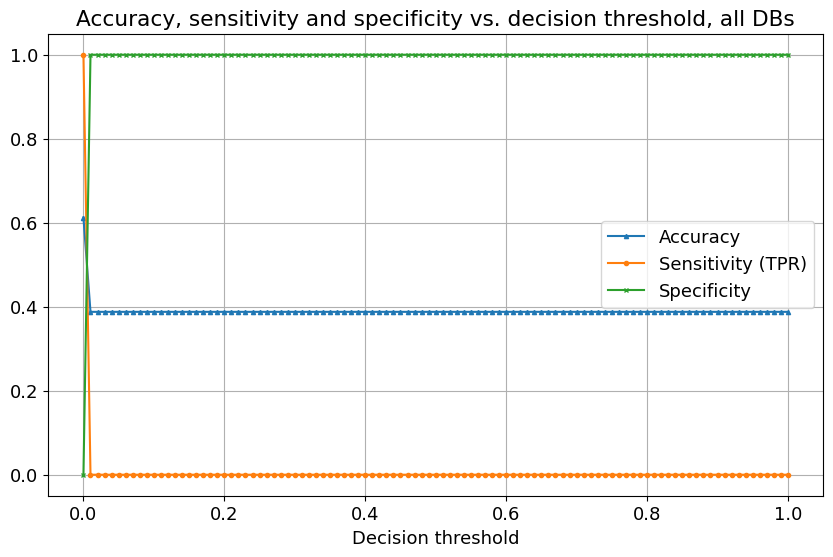

In [419]:
# Evaluate the model on the test set with a specified decision threshold
y_proba_custom = model_custom.predict_proba(X_test)[:, 1]

threshold = 0.2
y_pred_custom = (y_proba_custom >= threshold).astype(int)

# Compute confusion matrix to derive metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()
accuracy    = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

print("Custom Objective Model Performance:")
print(f"Accuracy    : {accuracy:.4f}")
print(f"Sensitivity : {sensitivity:.4f}")
print(f"Specificity : {specificity:.4f}\n")

thresholds = np.linspace(0, 1, 101)
plot_performance(y_test, y_proba_custom, thresholds)

In [271]:
# Train model with tuned hyperparameters found earlier with Optuna (all features, all DBs)
params = {
    'max_depth': 3,
    'learning_rate': 0.010264476378846001,
    'n_estimators': 315,
    'subsample': 0.9974019999587013,
    'colsample_bytree': 0.502030708468908,
    'gamma': 0.007512542128679911,
    'reg_alpha': 0.4864546932137364,
    'reg_lambda': 0.022896957970892487
}
    
# Create a new model with these parameters
model_tuned_stored_hyperparams = xgb.XGBClassifier(random_state=42, **params)

# Train model (all features)
model_tuned_stored_hyperparams.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.502030708468908, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.007512542128679911,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010264476378846001,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=315, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

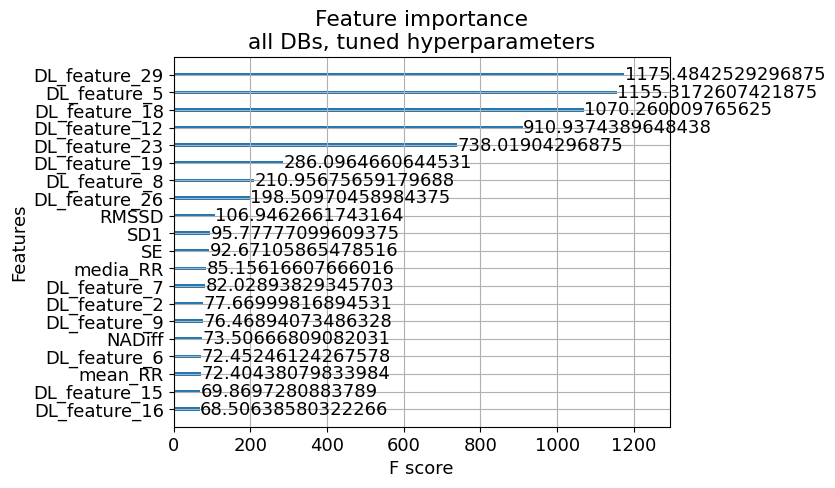

In [272]:
# Plot feature importance

#selected_model = "default"
#selected_model = "tuned"
selected_model = "tuned_stored_hyperparams"

if selected_model == "default":
    model = xgb_clf
    title_print = "default hyperparameters"
    
elif selected_model == "tuned":
    model = best_model
    title_print = "tuned hyperparameters"
    
elif selected_model == "tuned_stored_hyperparams":
    # With stored hyperparameters from Optuna from an earlier run
    model = model_tuned_stored_hyperparams
    title_print = "tuned hyperparameters"

xgb.plot_importance(model, max_num_features=20, title=f"Feature importance\n{db_print}, {title_print}", importance_type='gain')  # top 20
plt.show()

len(sorted_importance): 47

sorted_features: ['DL_feature_29', 'DL_feature_5', 'DL_feature_18', 'DL_feature_12', 'DL_feature_23', 'DL_feature_19', 'DL_feature_8', 'DL_feature_26', 'RMSSD', 'SD1', 'SE', 'media_RR', 'DL_feature_7', 'DL_feature_2', 'DL_feature_9', 'NADiff', 'DL_feature_6', 'mean_RR', 'DL_feature_15', 'DL_feature_16', 'NADev', 'DL_feature_17', 'DFA', 'DL_feature_27', 'DL_feature_4', 'pNN50', 'NN50', 'delta_RRImax', 'min_RR', 'LF power n.u.', 'CV', 'LF power', 'HF power', 'LF/HF ratio', 'HF power n.u.', 'Total power', 'SD2', 'RE', 'DL_feature_3', 'std_RR', 'DL_feature_1', 'DL_feature_32', 'VLF power', 'DL_feature_11', 'DL_feature_20', 'DL_feature_14', 'DL_feature_22']

DL features: ['DL_feature_1', 'DL_feature_2', 'DL_feature_3', 'DL_feature_4', 'DL_feature_5', 'DL_feature_6', 'DL_feature_7', 'DL_feature_8', 'DL_feature_9', 'DL_feature_11', 'DL_feature_12', 'DL_feature_14', 'DL_feature_15', 'DL_feature_16', 'DL_feature_17', 'DL_feature_18', 'DL_feature_19', 'DL_feature_20',

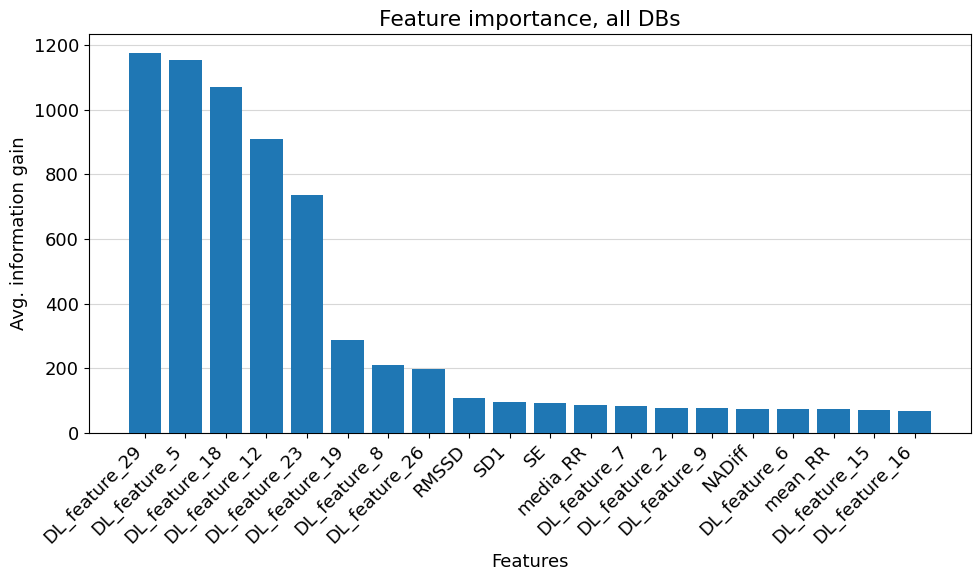

In [273]:
# Extract the top 20 features

# Plot and get feature importance scores (using 'gain' as an example)
importance_dict = model.get_booster().get_score(importance_type='gain')

# Sort features by importance
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features = []
sorted_scores_gain = []
for i in range(len(sorted_importance)):
    sorted_features.append(sorted_importance[i][0])
    sorted_scores_gain.append(sorted_importance[i][1])

top_20_features = sorted_features[:20]
top_20_scores_gain = sorted_scores_gain[:20]

top_10_features = sorted_features[:10]
top_10_scores_gain = sorted_scores_gain[:10]

# While we're at it, we can make lists with DL features and expert features
all_features = X_train.columns
dl_features = [feature for feature in all_features if "DL_" in feature]
expert_features = [feature for feature in all_features if "DL_" not in feature]

print("\nsorted_features:", sorted_features)
print("\nDL features:", dl_features)
print("\nExpert features:", expert_features)
print()

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.grid(axis='y', linestyle='-', alpha=0.5, zorder=0)
plt.bar(top_20_features, top_20_scores_gain, zorder=3)

# Rotate the feature names on the x-axis if needed
plt.xticks(rotation=45, ha='right')

plt.xlabel("Features")
plt.ylabel("Avg. information gain")
plt.title(f"Feature importance, {db_print}")
plt.tight_layout()
plt.show()


Data (sub)set: all DBs
Features used: Top 5 features
['DL_feature_29', 'DL_feature_5', 'DL_feature_18', 'DL_feature_12', 'DL_feature_23']
thresholds: [0.08 0.09 0.1  0.11]
sensitivities: [0.9641519529159979, 0.947565543071161, 0.9438202247191011, 0.9283039058319957]
specificities: [0.737331081081081, 0.8065878378378378, 0.8184121621621622, 0.862331081081081]
accuracies: [0.8761873566983295, 0.892892237143793, 0.8951850638716017, 0.9027186374058304]

Data (sub)set: db1
Features used: Top 5 features
['DL_feature_29', 'DL_feature_5', 'DL_feature_18', 'DL_feature_12', 'DL_feature_23']
thresholds: [0.08 0.09 0.1  0.11]
sensitivities: [0.9855072463768116, 0.9746376811594203, 0.9728260869565217, 0.9655797101449275]
specificities: [0.9473684210526315, 0.9597523219814241, 0.9721362229102167, 0.9907120743034056]
accuracies: [0.9714285714285714, 0.9691428571428572, 0.9725714285714285, 0.9748571428571429]


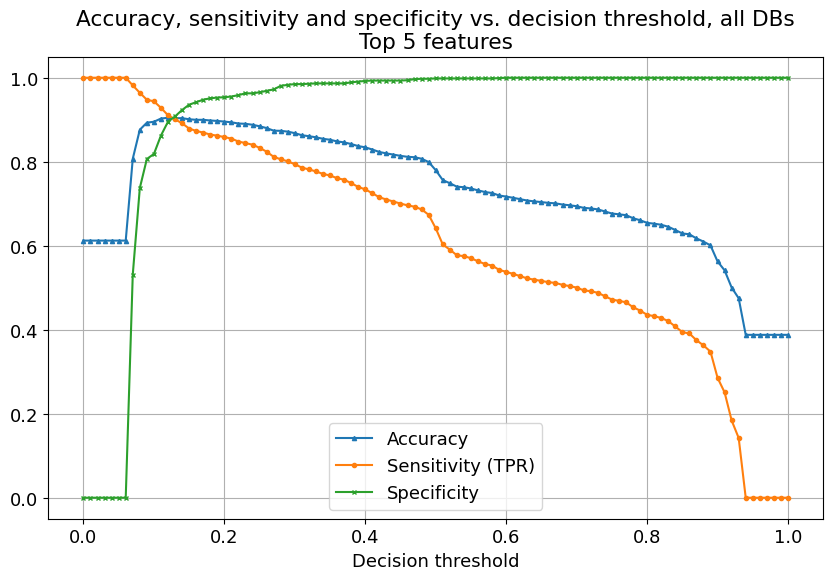

In [400]:
# Using the model selected previously (selected_model = ...)

#features_subset = "all features"
#features_subset = "top 20"
#features_subset = "top 10"
features_subset = "top n"; n_features = 5 # Specify how many features to include
#features_subset = "dl only"
#features_subset = "expert only"
#features_subset = "custom selection"

if features_subset == "all features":
    X_train_subset = X_train
    X_test_subset = X_test
    X_test_subset_eval = X_test_eval # Eval subset is specified in cell 2
    print_features = "All features"
    
elif features_subset == "top 20":
    X_train_subset = X_train[top_20_features]
    X_test_subset = X_test[top_20_features]
    X_test_subset_eval = X_test_eval[top_20_features]
    print_features = "Top 20 features"
    
elif features_subset == "top 10":
    X_train_subset = X_train[top_10_features]
    X_test_subset = X_test[top_10_features]
    X_test_subset_eval = X_test_eval[top_10_features]
    print_features = "Top 10 features"

elif features_subset == "top n":
    top_n_features = sorted_features[:n_features]
    X_train_subset = X_train[top_n_features]
    X_test_subset = X_test[top_n_features]
    X_test_subset_eval = X_test_eval[top_n_features]
    print_features = f"Top {n_features} features"
    
elif features_subset == "dl only":
    X_train_subset = X_train[dl_features]
    X_test_subset = X_test[dl_features]
    X_test_subset_eval = X_test_eval[dl_features]
    print_features = "DL features only"
    
elif features_subset == "expert only":
    X_train_subset = X_train[expert_features]
    X_test_subset = X_test[expert_features]
    X_test_subset_eval = X_test_eval[expert_features]
    print_features = "Expert features only"

elif features_subset == "custom selection":
    features_to_include = ["mean_RR", "DL_feature_7"]
    X_train_subset = X_train[features_to_include]
    X_test_subset = X_test[features_to_include]
    X_test_subset_eval = X_test_eval[features_to_include]
    print_features = "mean_RR and DL_feature_7 only"

model.fit(X_train_subset, y_train)

y_proba = model.predict_proba(X_test_subset)[:, 1]
y_proba_eval = model.predict_proba(X_test_subset_eval)[:, 1]

# Threshold values to plot
thresholds = np.linspace(0, 1, 101)

accuracies, sensitivities, specificities = get_performance(y_test, y_proba, thresholds)

# Performance of the chosen evaluation subset (if relevant) 
accuracies_eval, sensitivities_eval, specificities_eval = get_performance(y_test_eval, y_proba_eval, thresholds)

# Plot
custom_title = f"Accuracy, sensitivity and specificity vs. decision threshold, {db_print}\n{print_features}"
plot_performance(y_test, y_proba, thresholds, custom_title=custom_title)

type(axes): <class 'numpy.ndarray'>
axes.shape: (2, 2)
type(axes[0]): <class 'numpy.ndarray'>
type(axes.ravel()): <class 'numpy.ndarray'>
axes.ravel().shape: (4,)


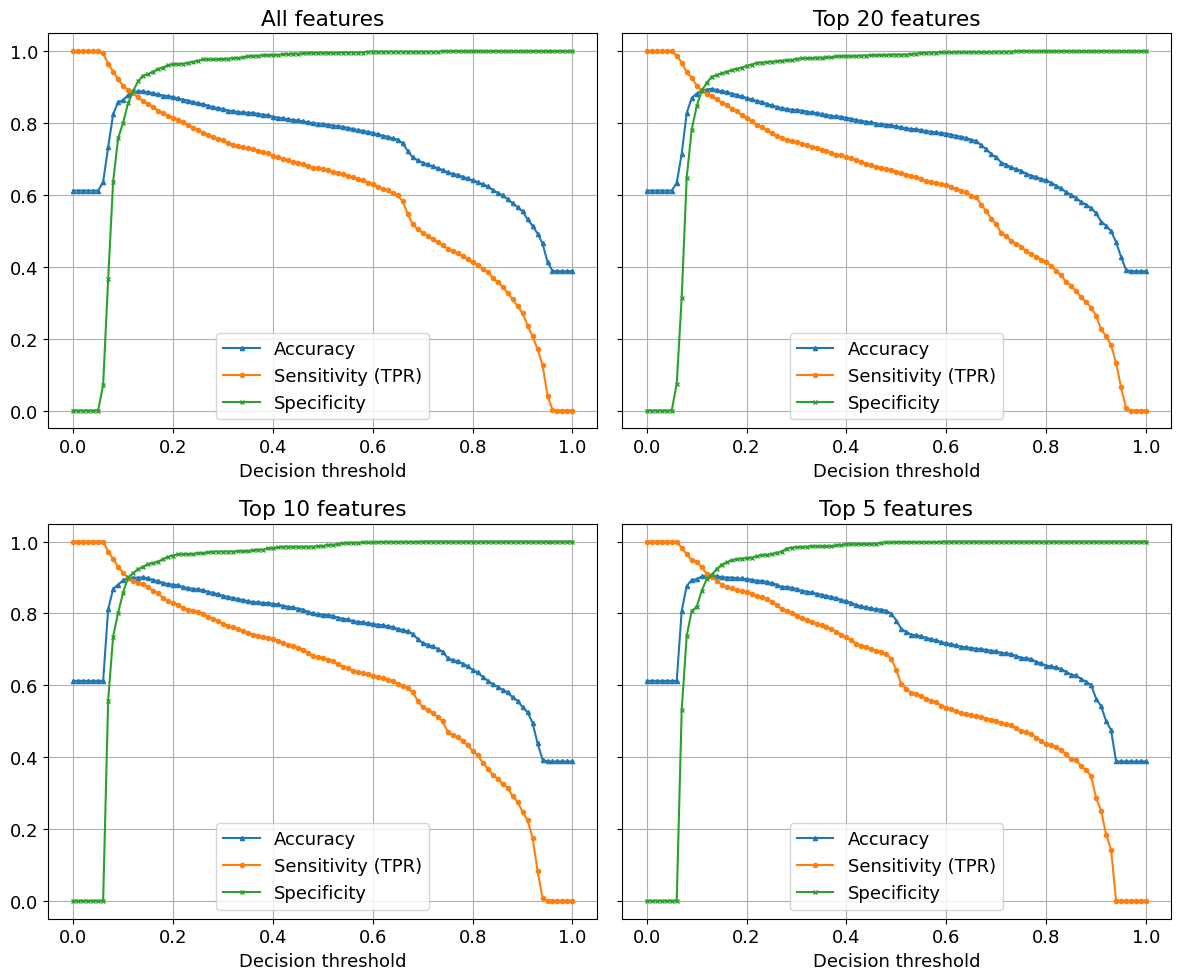

In [342]:
# Plot the performance results of multiple feature subset in one plot

features_selection = 1 # Select the feature subset to plot (1, 2 or 3)

if features_selection == 1:
    features_subsets = [
        [list(X_train.columns), "All features"], # all features
        [sorted_features[:20], "Top 20 features"], # Top 20 features
        [sorted_features[:10], "Top 10 features"], # Top 10 features
        [sorted_features[:5], "Top 5 features"] # Top 5 features
    ]

    # Subplot layout
    n_rows = 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)

elif features_selection == 2:
    features_subsets = [
        [sorted_features[:3], "Top 3 features"], # Top 3 features
        [sorted_features[:1], "Top 1 feature"], # Top 1 feature
        [["DL_feature_5"], "DL feature 5 only"], # DL_feature_5
        [["mean_RR", "DL_feature_7"], "mean_RR and DL feature 7 only"]
    ]

    # Subplot layout
    n_rows = 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)

elif features_selection == 3:
    features_subsets = [
        [dl_features, "DL features only"], # DL features only
        [expert_features, "Expert features only"] # Expert features only
    ]

    # Subplot layout
    n_rows = 1
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)

# Loop over each feature subset
for ax, (features, subset_name) in zip(axes.ravel(), features_subsets):
    # Subset the data
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    
    # Fit model
    model.fit(X_train_subset, y_train)
    
    # Predict probabilities
    thresholds = np.linspace(0, 1, 101)
    y_proba = model.predict_proba(X_test_subset)[:, 1]
    
    # Plot on the current subplot
    add_plot_to_ax(
        ax=ax,
        y_true=y_test,
        y_proba=y_proba,
        thresholds=thresholds,
        custom_title=subset_name
    )

plt.tight_layout()
plt.show()

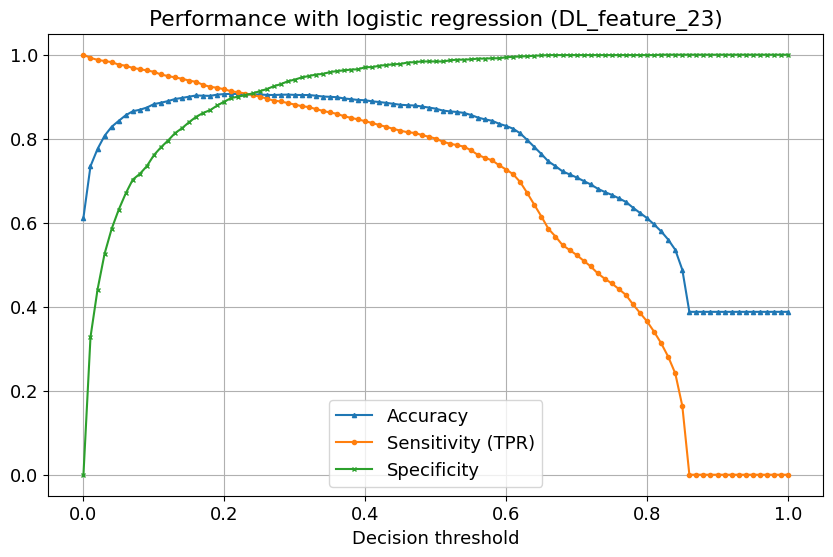

In [335]:
# Compare with logistic regression

feature_to_include = "DL_feature_29"
#feature_to_include = "DL_feature_23"
#feature_to_include = "DL_feature_19"
#feature_to_include = "media_RR"

feature_subset = [feature_to_include]
X_train_subset = X_train[feature_subset]
X_test_subset = X_test[feature_subset]

# Handle NaNs with imputation
imputer = SimpleImputer(strategy='mean')  # or 'median', etc.
X_train_subset_imputed = pd.DataFrame(imputer.fit_transform(X_train_subset), columns=X_train_subset.columns)
X_test_subset_imputed = pd.DataFrame(imputer.transform(X_test_subset), columns=X_test_subset.columns)

# Create a logistic regression model
lr_model = LogisticRegression(random_state=42)

# Fit the model
lr_model.fit(X_train_subset_imputed, y_train)

# Get predicted probabilities
y_proba_lr = lr_model.predict_proba(X_test_subset_imputed)[:, 1]

# Define thresholds
thresholds = np.linspace(0, 1, 101)

plot_performance(y_test, y_proba_lr, thresholds, custom_title=f"Performance with logistic regression ({feature_to_include})")

if False:
    # Plot the performance metrics
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies_lr, label="Accuracy", marker="^", markersize=3)
    plt.plot(thresholds, sensitivities_lr, label="Sensitivity (TPR)", marker="o", markersize=3)
    plt.plot(thresholds, specificities_lr, label="Specificity", marker="x", markersize=3)
    plt.xlabel("Decision Threshold")
    plt.ylabel("Metric Value")
    plt.title("Performance with Logistic Regression (Top 1 Feature)")
    plt.legend()
    plt.grid(True)
    plt.show()

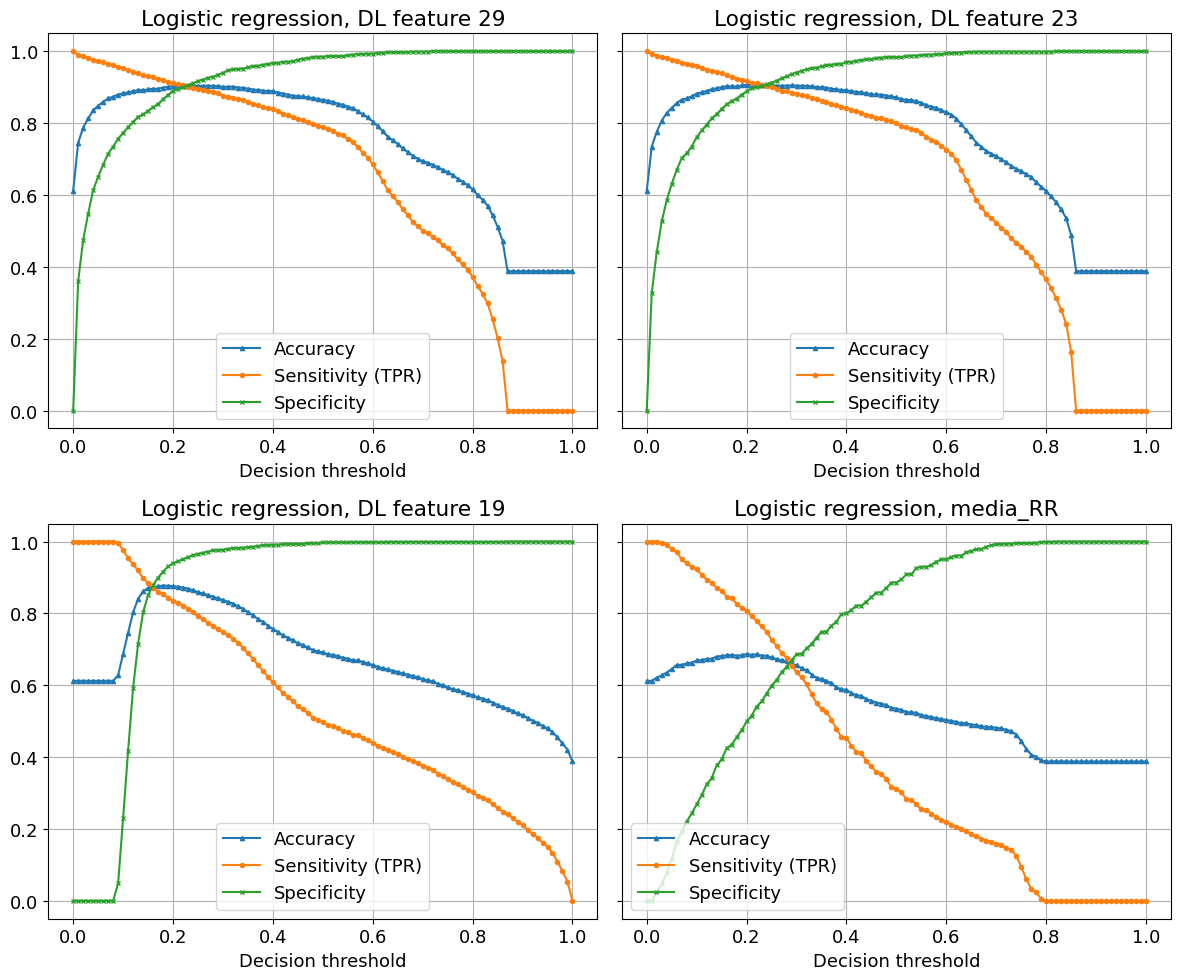

In [341]:
# More flexible plotting of the logistic regression plots, using subplots
features_subsets = [
    [["DL_feature_29"], "DL feature 29"],
    [["DL_feature_23"], "DL feature 23"],
    [["DL_feature_19"], "DL feature 19"],
    [["media_RR"], "media_RR"]
]

# Subplot layout
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)

# Create logistic regression model
lr_model = LogisticRegression(random_state=42)

# Loop over each feature subset
for ax, (features, subset_name) in zip(axes.ravel(), features_subsets):
    # Subset the data
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Handle NaNs with imputation
    imputer = SimpleImputer(strategy='mean')  # or 'median', etc.
    X_train_subset_imputed = pd.DataFrame(imputer.fit_transform(X_train_subset), columns=X_train_subset.columns)
    X_test_subset_imputed = pd.DataFrame(imputer.transform(X_test_subset), columns=X_test_subset.columns)
    
    # Fit model
    lr_model.fit(X_train_subset_imputed, y_train)
    
    # Predict probabilities
    thresholds = np.linspace(0, 1, 101)
    y_proba = lr_model.predict_proba(X_test_subset_imputed)[:, 1]
    
    # Plot on the current subplot
    add_plot_to_ax(
        ax=ax,
        y_true=y_test,
        y_proba=y_proba,
        thresholds=thresholds,
        custom_title=f"Logistic regression, {subset_name}"
    )

plt.tight_layout()
plt.show()